### <center>Parking Tickets Exploratory Data Analysis</center>

<b>Data Source</b>: FOIA; parking ticket data from 2015 to 2019 for Ann Arbor Michigan

<b>Problem Statement</b>: I came across this data as part of one of my first classes on Pandas. My goal was just to explore the data further to see if I can find any interested trends

<b>Key Observation</b>: Its interesting to see total number of tickets issued per year trending downwards but the total amount of fines staying relatively flat. This would typically be indicative of increase in the average amount fined per ticket, which is exactly the trend we see in 2018. 

I also found [this](https://www.mlive.com/news/ann-arbor/2018/06/ann_arbor_parking_ticket_fine.html) interesting article corroborating these findings.

![TrendsinParkingTickets.png](TrendsinParkingTickets.png)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option("display.max_row",None)
pd.set_option("display.max_columns",100)
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def load_ticket_data():

    file_names = ["AnnArbor-TicketViolation2015.xls", "AnnArbor-TicketViolation2016.xls",
                  "AnnArbor-TicketViolation2017.xls", "AnnArbor-TicketViolation2018.xls",
                  "AnnArbor-TicketViolation2019.xls"]

    df = pd.DataFrame()       
    
    for f in file_names:       
        xls = pd.read_excel(f, sheet_name = None, skiprows = 1, header = None, parse_dates = True) #, parse_dates = [2,3])
        for s in list(xls.keys()):
            df = df.append(xls[s])

    #clean up columns names
    df.columns = ['Ticket#', 'Badge', 'Issue_Date','Issue_Time', 'Plate', 'State', 'Make', 'Model', 'Violation', 
                  'Description', 'Location', 'Meter', 'Fine', 'Penalty']   
    df = df[(df["Ticket#"] != "Ticket #") & (df["Ticket#"] != "Grand Totals:")]  
    
    #date conversions
    df["Issue_Date"] = pd.to_datetime(df["Issue_Date"])
    df["Issue_Month"] = df["Issue_Date"].dt.month
    df["Issue_Year"] = df["Issue_Date"].dt.year
    df['Issue_Time'] = pd.to_datetime(df['Issue_Time'], format= '%H%M', errors ="coerce").dt.time
    
    #dropping missing values
    df.drop(labels =["Model"], axis = 1, inplace = True)
    df.dropna(subset = ["Issue_Time","Violation","Description"], axis = 0, how = "any", inplace = True)
    
    #dropping incorrect "Make" values
    df["temp"] = pd.to_numeric(df["Make"], errors ="coerce")
    df = df[df["temp"].isna()]
    df.drop(labels = ["temp"], axis = 1, inplace = True)

    return df

In [3]:
df = load_ticket_data()
# df.info()
df.head(3)

,Ticket#,Badge,Issue_Date,Issue_Time,Plate,State,Make,Violation,Description,Location,Meter,Fine,Penalty,Issue_Month,Issue_Year
1,H000210594,036,2015-01-01,22:14:00,LAS5658,OH,SUBA,A04,NO PRKNG ANYTME,525 ELM,NaN,35,20,1,2015
2,2100005782,821,2015-01-02,08:24:00,DEZ4465,MI,FORD,A01,EXPIRED METER,600 BLK OF STATE SOU,4006A,10,0,1,2015
3,2110008524,826,2015-01-02,17:19:00,DCM1327,MI,SATU,A01,EXPIRED METER,FARMER'S MARKET,17,10,0,1,2015


In [4]:
_ = df.groupby("Issue_Year").agg(total_num_tickets = ("Fine", "size"),
                                 total_fine_amt = ("Fine", "sum"), 
                                 avg_fine_amt = ("Fine", "mean")).astype("float")

_["total_num_tickets (100K)"] = (_["total_num_tickets"] / 100000) #100K
_["total_fine_amt (MM)"] = (_["total_fine_amt"] / 1000000) #1MM
_.drop(labels = ["total_num_tickets", "total_fine_amt"], axis = 1, inplace = True)
tickets_fines_summary = _.round(2)
tickets_fines_summary

,avg_fine_amt,total_num_tickets (100K),total_fine_amt (MM)
Issue_Year,,,
2015,18.50,1.60,2.96
2016,18.99,1.64,3.12
2017,19.59,1.66,3.26
2018,19.86,1.57,3.13
2019,21.44,1.48,3.17


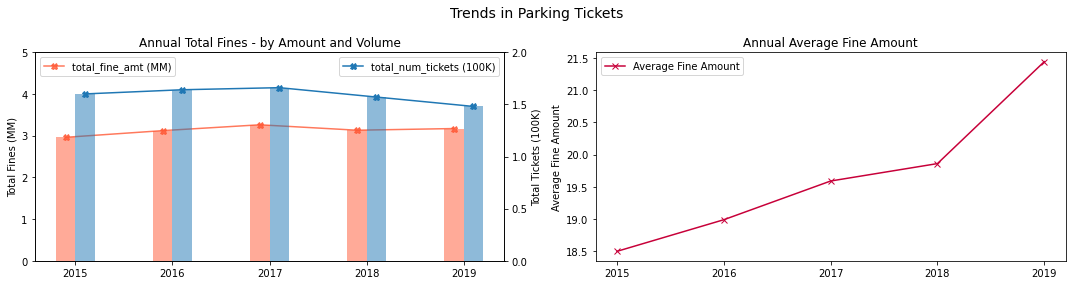

In [11]:
w = 0.2
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.bar(tickets_fines_summary.index, tickets_fines_summary["total_fine_amt (MM)"], 
          width = w, alpha = 0.5, color = "#FF5733")
plt.plot(tickets_fines_summary["total_fine_amt (MM)"], marker = "X", alpha = 0.8, color = "#FF5733", 
         label = "total_fine_amt (MM)")
plt.yticks(np.arange(0,6))
plt.ylabel("Total Fines (MM)")
plt.legend(loc = 2)


plt.twinx()
plt.bar(tickets_fines_summary.index + w, tickets_fines_summary["total_num_tickets (100K)"], 
          width = w, alpha = 0.5)
plt.plot(tickets_fines_summary.index + w, tickets_fines_summary["total_num_tickets (100K)"], marker = "X", label = "total_num_tickets (100K)")
plt.yticks(np.arange(0, 2.5, 0.5))
plt.ylabel("Total Tickets (100K)")
plt.legend(loc = 1)


plt.gca().set_xticks(tickets_fines_summary.index + w/2)
plt.gca().set_xticklabels(["2015", "2016", "2017", "2018", "2019"])
plt.title("Annual Total Fines - by Amount and Volume")

plt.subplot(1, 2, 2)
plt.plot(tickets_fines_summary["avg_fine_amt"], marker = "x", color = "#C70039", label = "Average Fine Amount")
plt.xticks(tickets_fines_summary.index)
plt.gca().set_xticklabels(["2015", "2016", "2017", "2018", "2019"])
plt.legend(loc = 2)
plt.ylabel("Average Fine Amount")
plt.title("Annual Average Fine Amount")


plt.suptitle("Trends in Parking Tickets", fontsize = 14)
plt.tight_layout()
# plt.show()
plt.savefig("TrendsinParkingTickets")

<center><b>Observation 1</b></center>
Its interesting to see total number of tickets issued per year trending downwards but the total amount of fines staying relatively flat. This would typically be indicative of increase in the average amount fined per ticket, which is exactly the trend we see in 2018. 

I also found this interesting article corroborating these findings [1](https://www.mlive.com/news/ann-arbor/2018/06/ann_arbor_parking_ticket_fine.html).

In [6]:
"""Top Fine Categories in Each Year"""

def formatter(x):
    return f'({abs(x)})' if x < 0 else x

def top_fine_categories(df, i, c, a, v, unit = 1):
    df_pt = pd.pivot_table(data = df, index = i, columns = c, aggfunc = a, values = v).transpose()
    df_pt.columns = list(df_pt.columns.values.astype('str'))
    df_pt.sort_values("2019", ascending = False, inplace = True)
    df_pt = (df_pt/unit).astype("float").round(2) 
    
    for i in range(len(df_pt.columns)-1):
        col = str(df_pt.columns[i + 1])
        df_pt[col + "vsPY_%diff"] = ((df_pt[col] - df_pt.iloc[:,i]) / df_pt.iloc[:,i] * 100).round(2).apply(formatter)
    
    return df_pt

In [7]:
num_of_tickets =  top_fine_categories(df, "Issue_Year", "Description", 'count', 'Fine', 1000)
num_of_tickets.head()

,2015,2016,2017,2018,2019,2016vsPY_%diff,2017vsPY_%diff,2018vsPY_%diff,2019vsPY_%diff
Description,,,,,,,,,
EXPIRED METER,100.01,97.17,90.58,85.68,78.36,(2.84),(6.78),(5.41),(8.54)
NO PERMITS U/M,20.96,23.55,31.35,29.80,28.36,12.36,33.12,(4.94),(4.83)
OTHER,8.68,11.55,14.27,12.91,11.61,33.06,23.55,(9.53),(10.07)
OVER LEGAL TIME LIMIT,NaN,NaN,NaN,3.20,6.48,NaN,NaN,NaN,102.5
NO PRKNG ANYTME,5.83,5.47,5.50,5.15,5.66,(6.17),0.55,(6.36),9.9


In [8]:
total_fine_amt = top_fine_categories(df, "Issue_Year", "Description", 'sum', 'Fine', 1000000)
total_fine_amt.head()

,2015,2016,2017,2018,2019,2016vsPY_%diff,2017vsPY_%diff,2018vsPY_%diff,2019vsPY_%diff
Description,,,,,,,,,
EXPIRED METER,1.34,1.33,1.25,1.29,1.38,(0.75),(6.02),3.2,6.98
NO PERMITS U/M,0.41,0.46,0.62,0.59,0.57,12.2,34.78,(4.84),(3.39)
OTHER,0.21,0.27,0.33,0.30,0.27,28.57,22.22,(9.09),(10.0)
OVER LEGAL TIME LIMIT,NaN,NaN,NaN,0.09,0.18,NaN,NaN,NaN,100.0
NO PRKNG ANYTME,0.16,0.16,0.16,0.15,0.16,0.0,0.0,(6.25),6.67


In [9]:
avg_fine_per_ticket = top_fine_categories(df, "Issue_Year", "Description", 'mean', 'Fine')
avg_fine_per_ticket.head()

,2015,2016,2017,2018,2019,2016vsPY_%diff,2017vsPY_%diff,2018vsPY_%diff,2019vsPY_%diff
Description,,,,,,,,,
HANDICAP,109.38,108.29,107.85,103.27,103.58,(1.0),(0.41),(4.25),0.3
BLOCKING TRAFFI,44.74,40.14,46.06,45.26,44.57,(10.28),14.75,(1.74),(1.52)
ABANDONED VEHIC,45.84,45.62,46.11,43.88,43.66,(0.48),1.07,(4.84),(0.5)
STREET MAINTENA,41.69,43.34,43.45,41.49,42.14,3.96,0.25,(4.51),1.57
PARKED ON WALK,42.12,42.22,41.79,42.88,41.96,0.24,(1.02),2.61,(2.15)


In [10]:
avg_fine_per_ticket.loc[["EXPIRED METER","NO PERMITS U/M","OTHER", "OVER LEGAL TIME LIMIT","NO PRKNG ANYTME"],:]

,2015,2016,2017,2018,2019,2016vsPY_%diff,2017vsPY_%diff,2018vsPY_%diff,2019vsPY_%diff
Description,,,,,,,,,
EXPIRED METER,13.42,13.67,13.80,15.08,17.57,1.86,0.95,9.28,16.51
NO PERMITS U/M,19.56,19.67,19.74,19.86,19.95,0.56,0.36,0.61,0.45
OTHER,24.30,23.08,22.88,22.85,23.58,(5.02),(0.87),(0.13),3.19
OVER LEGAL TIME LIMIT,NaN,NaN,NaN,28.78,28.11,NaN,NaN,NaN,(2.33)
NO PRKNG ANYTME,28.25,28.40,28.53,28.50,28.36,0.53,0.46,(0.11),(0.49)


<center><b>Observation 2</b></center>

* Fines for Expired Meters are a significant contributor by both total total volume as well as total fine amount annually
* Significant increases in Expired Meter fines per ticket (~9% in 2018 and again ~16.5% in 2019)
* Other significant types of tickets include those for No Permit, No Parking, Parking over the Legal Time Limit and Other

<b>References:</b>

[1] https://www.mlive.com/news/ann-arbor/2018/06/ann_arbor_parking_ticket_fine.html